# **1. 데이터 처리**

In [ ]:
import json
import pandas as pd
import glob
import os
import math
import numpy as np
import time

# ==========================================
# [설정] 사용자 환경에 맞게 수정하세요
# ==========================================
LOG_FOLDER_PATH = 'G:/내 드라이브/pubg_telemetry_summary'          # 로그 파일들이 있는 폴더 경로
OUTPUT_FILE = 'pubg_hierarchical_dataset.csv' # 결과 저장 파일명
BATCH_SIZE = 100                    # 100개 파일 처리할 때마다 CSV 저장

# 분석 파라미터 (기존 로직 유지)
TIME_INTERVAL_SEC = 10
START_ALIVE_THRESHOLD = 10
AI_TEAM_ID_START = 200
MAX_AI_RATIO = 0.4
STALE_THRESHOLD_SEC = 60

In [9]:
# ==========================================
# [헬퍼 함수]
# ==========================================
def get_item_level(item_id):
    if not isinstance(item_id, str): return 0
    if 'Lv3' in item_id: return 3
    if 'Lv2' in item_id: return 2
    if 'Lv1' in item_id: return 1
    if 'Head' in item_id:
        if 'Head_G' in item_id: return 3
        if 'Head_F' in item_id: return 2
        if 'Head_E' in item_id: return 1
    if 'Armor' in item_id or 'Vest' in item_id:
        if 'Armor_E' in item_id: return 3
        if 'Armor_D' in item_id: return 2
        if 'Armor_C' in item_id: return 1
    return 0

def get_throwable_type(item_id):
    if not isinstance(item_id, str): return None
    if 'Smoke' in item_id: return 'smoke'
    if 'Grenade' in item_id and 'Bluezone' not in item_id: return 'grenade'
    return None

def process_hierarchical_data(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            logs = [json.loads(line) for line in f]
    except Exception as e:
        # print(f"Error reading {file_path}: {e}")
        return None

    # AI Ratio Check
    all_players = set(); human_players = set()
    for log in logs:
        if log.get('_T') == 'LogPlayerPosition':
            c = log.get('character', {})
            name = c.get('name')
            if name:
                all_players.add(name)
                if c.get('teamId', -1) < AI_TEAM_ID_START: human_players.add(name)
    
    if not all_players or (1 - len(human_players)/len(all_players)) > MAX_AI_RATIO:
        return None

    # Init
    current_alive = 100
    team_players = {}
    team_ranks = {}
    p_status = {}
    p_gear = {}
    p_throw = {}
    p_kills = {}
    curr_safe_zone = {'x': 400000, 'y': 400000}
    
    next_snap = 0
    recording = False
    target_teams = set()
    data_rows = []

    # Build Teams
    for log in logs:
        if log.get('_T') == 'LogPlayerPosition':
            c = log.get('character', {})
            tid = c.get('teamId', -1)
            name = c.get('name')
            if tid != -1 and tid < AI_TEAM_ID_START and name:
                if tid not in team_players: team_players[tid] = set()
                team_players[tid].add(name)
                if c.get('ranking', 0) != 0: team_ranks[tid] = c.get('ranking')

    # Process Logs
    for log in logs:
        log_type = log.get('_T')
        elapsed = log.get('elapsedTime', 0)
        
        if log_type == 'LogGameStatePeriodic':
            sz = log.get('gameState', {}).get('safetyZonePosition', {})
            if sz: curr_safe_zone = {'x': sz.get('x'), 'y': sz.get('y')}

        elif log_type == 'LogPlayerPosition':
            if 'numAlivePlayers' in log: current_alive = log['numAlivePlayers']
            c = log.get('character', {})
            name = c.get('name')
            if name:
                p_status[name] = {
                    'hp': c.get('health', 0),
                    'dbno': 1 if c.get('isDBNO', False) else 0,
                    'veh': 1 if c.get('isInVehicle', False) else 0,
                    'loc': c.get('location', {}),
                    'last_update': elapsed
                }

        elif log_type == 'LogItemEquip':
            item = log.get('item', {})
            name = log.get('character', {}).get('name')
            if name:
                lvl = get_item_level(item.get('itemId', ''))
                if lvl > 0:
                    if name not in p_gear: p_gear[name] = {'helm': 0, 'vest': 0}
                    if 'Head' in item.get('itemId', ''): p_gear[name]['helm'] = lvl
                    else: p_gear[name]['vest'] = lvl

        elif log_type == 'LogItemPickup':
            item = log.get('item', {})
            name = log.get('character', {}).get('name')
            if name:
                tt = get_throwable_type(item.get('itemId', ''))
                if tt:
                    if name not in p_throw: p_throw[name] = {'smoke': 0, 'nade': 0}
                    if tt == 'smoke': p_throw[name]['smoke'] += item.get('stackCount', 1)
                    elif tt == 'grenade': p_throw[name]['nade'] += item.get('stackCount', 1)

        elif log_type == 'LogPlayerKillV2':
            k = log.get('killer', {})
            v = log.get('victim', {})
            if v and v.get('name') in p_status: p_status[v['name']]['hp'] = 0
            if k and k.get('name'):
                kname = k['name']
                p_kills[kname] = p_kills.get(kname, 0) + 1

        # Trigger
        if not recording:
            if elapsed > 300 and current_alive <= START_ALIVE_THRESHOLD:
                recording = True
                next_snap = elapsed
                for tid, mems in team_players.items():
                    alive = False
                    for m in mems:
                        s = p_status.get(m, {})
                        if s.get('hp', 0) > 0 and (elapsed - s.get('last_update', 0) <= STALE_THRESHOLD_SEC):
                            alive = True; break
                    if alive: target_teams.add(tid)

        # Snapshot
        if recording and elapsed >= next_snap:
            # Z 표준화용 통계
            all_z = []
            for tid in target_teams:
                for m in team_players[tid]:
                    s = p_status.get(m, {})
                    if s.get('hp', 0) > 0 and s.get('loc'):
                        all_z.append(s['loc'].get('z', 0))
            z_mean = np.mean(all_z) if all_z else 0
            z_std = np.std(all_z) + 1e-5 if all_z else 1

            for tid in target_teams:
                mems = list(team_players[tid])
                team_row = {
                    'match_id': os.path.basename(file_path),
                    'time_sec': next_snap,
                    'team_id': tid,
                    'is_winner': 1 if team_ranks.get(tid, 100) == 1 else 0
                }
                
                alive_cnt = 0
                total_hp = 0
                
                for i in range(4): # Max 4 players
                    prefix = f"P{i+1}_"
                    if i < len(mems):
                        m = mems[i]
                        s = p_status.get(m, {})
                        g = p_gear.get(m, {'helm': 0, 'vest': 0})
                        t = p_throw.get(m, {'smoke': 0, 'nade': 0})
                        k = p_kills.get(m, 0)
                        
                        if s.get('hp', 0) > 0 and (elapsed - s.get('last_update', 0) <= STALE_THRESHOLD_SEC):
                            alive_cnt += 1
                            total_hp += s['hp']
                            loc = s.get('loc', {'x':0, 'y':0, 'z':0})
                            
                            team_row[prefix+'health'] = s['hp']
                            team_row[prefix+'groggy'] = s['dbno']
                            team_row[prefix+'helm'] = g['helm']
                            team_row[prefix+'vest'] = g['vest']
                            team_row[prefix+'smoke'] = t['smoke']
                            team_row[prefix+'nade'] = t['nade']
                            team_row[prefix+'kill'] = k
                            team_row[prefix+'veh'] = s['veh']
                            team_row[prefix+'rel_x'] = loc.get('x', 0) - curr_safe_zone['x']
                            team_row[prefix+'rel_y'] = loc.get('y', 0) - curr_safe_zone['y']
                            team_row[prefix+'z'] = (loc.get('z', 0) - z_mean) / z_std
                        else:
                            for feat in ['health','groggy','helm','vest','smoke','nade','kill','veh','rel_x','rel_y','z']:
                                team_row[prefix+feat] = 0
                    else:
                        for feat in ['health','groggy','helm','vest','smoke','nade','kill','veh','rel_x','rel_y','z']:
                            team_row[prefix+feat] = 0

                team_row['num_alive'] = alive_cnt
                team_row['total_health'] = round(total_hp, 2)
                data_rows.append(team_row)
                
            next_snap += TIME_INTERVAL_SEC

    # [Optimization] 소수점 둘째자리 반올림
    return pd.DataFrame(data_rows).round(2) if data_rows else None


In [11]:
# ==========================================
# [실행부]
# ==========================================
if __name__ == "__main__":
    # 1. 파일 목록 검색 (두 가지 패턴 모두)
    patterns = ["*squad_Baltic_Main.jsonl", "*squad_Tiger_Main.jsonl", "*squad_Desert_Main.jsonl"]
    all_files = []
    for pattern in patterns:
        all_files.extend(glob.glob(os.path.join(LOG_FOLDER_PATH, pattern)))
        
    total_files = len(all_files)
    print(f"🚀 데이터셋 구축 시작 (총 {total_files}개 파일)")
    
    start_time = time.time()
    df_buffer = []
    processed_count = 0
    error_count = 0
    skipped_count = 0
    
    # 기존 파일 초기화
    if os.path.exists(OUTPUT_FILE):
        os.remove(OUTPUT_FILE)
        print(f"ℹ️ 기존 {OUTPUT_FILE} 삭제됨 (새로 생성)")

    # 2. 파일 처리 루프
    for i, fpath in enumerate(all_files):
        try:
            res = process_hierarchical_data(fpath)
            
            if res is not None:
                df_buffer.append(res)
                processed_count += 1
            else:
                skipped_count += 1
                
        except Exception as e:
            # print(f"⚠️ Error processing {os.path.basename(fpath)}: {e}")
            error_count += 1
        
        # 3. 배치 단위 저장 (메모리 절약)
        if (i + 1) % BATCH_SIZE == 0 or (i + 1) == total_files:
            if df_buffer:
                batch_df = pd.concat(df_buffer, ignore_index=True)
                
                # 첫 저장이면 헤더 포함, 아니면 이어쓰기
                if not os.path.exists(OUTPUT_FILE):
                    batch_df.to_csv(OUTPUT_FILE, index=False, mode='w', encoding='utf-8-sig')
                else:
                    batch_df.to_csv(OUTPUT_FILE, index=False, mode='a', header=False, encoding='utf-8-sig')
                
                print(f"💾 [Auto Save] {len(batch_df)}행 저장 완료 (진행률: {i+1}/{total_files})")
                df_buffer = [] # 버퍼 비우기
            else:
                print(f"ℹ️ [Auto Save] 저장할 데이터 없음 (진행률: {i+1}/{total_files})")

    elapsed_time = time.time() - start_time
    print("\n" + "="*30)
    print(f"✅ 모든 작업 완료! ({elapsed_time:.1f}초 소요)")
    print(f" - 성공: {processed_count}개")
    print(f" - 스킵(AI/데이터부족): {skipped_count}개")
    print(f" - 에러: {error_count}개")
    print(f"📂 최종 파일: {OUTPUT_FILE}")
    print("="*30)

🚀 데이터셋 구축 시작 (총 3848개 파일)
ℹ️ 기존 pubg_hierarchical_dataset.csv 삭제됨 (새로 생성)
💾 [Auto Save] 2944행 저장 완료 (진행률: 100/3848)
💾 [Auto Save] 2944행 저장 완료 (진행률: 100/3848)
💾 [Auto Save] 5141행 저장 완료 (진행률: 200/3848)
💾 [Auto Save] 5141행 저장 완료 (진행률: 200/3848)
💾 [Auto Save] 4214행 저장 완료 (진행률: 300/3848)
💾 [Auto Save] 4214행 저장 완료 (진행률: 300/3848)
💾 [Auto Save] 2513행 저장 완료 (진행률: 400/3848)
💾 [Auto Save] 2513행 저장 완료 (진행률: 400/3848)
💾 [Auto Save] 3055행 저장 완료 (진행률: 500/3848)
💾 [Auto Save] 3055행 저장 완료 (진행률: 500/3848)
💾 [Auto Save] 2512행 저장 완료 (진행률: 600/3848)
💾 [Auto Save] 2512행 저장 완료 (진행률: 600/3848)
💾 [Auto Save] 2775행 저장 완료 (진행률: 700/3848)
💾 [Auto Save] 2775행 저장 완료 (진행률: 700/3848)
💾 [Auto Save] 2885행 저장 완료 (진행률: 800/3848)
💾 [Auto Save] 2885행 저장 완료 (진행률: 800/3848)
💾 [Auto Save] 2380행 저장 완료 (진행률: 900/3848)
💾 [Auto Save] 2380행 저장 완료 (진행률: 900/3848)
💾 [Auto Save] 2917행 저장 완료 (진행률: 1000/3848)
💾 [Auto Save] 2917행 저장 완료 (진행률: 1000/3848)
💾 [Auto Save] 3012행 저장 완료 (진행률: 1100/3848)
💾 [Auto Save] 3012행 저장 완료 (진행률: 1100/3848

# **2. 데이터셋 클래스 구축 및 모델 학습**

In [16]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os

# ==========================================
# [1] 설정 (Configuration)
# ==========================================
DATA_FILE = 'pubg_hierarchical_dataset.csv' # 데이터셋 파일명
MODEL_PATH = 'pubg_win_model.pth'           # 저장할 모델명

# 모델 파라미터
MAX_TEAMS = 10       # 한 게임 최대 팀 수 (Padding용)
PLAYER_FEATS = 11    # 플레이어 변수 개수
TEAM_FEATS = 2       # 팀 변수 개수
HIDDEN_DIM = 32      # 모델 크기 (작아도 충분함)
BATCH_SIZE = 64
EPOCHS = 30
LR = 0.0005
DROPOUT = 0.3   # 드롭아웃 추가

# 변수 컬럼 정의
P_COLS = ['health', 'groggy', 'helm', 'vest', 'smoke', 'nade', 'kill', 'veh', 'rel_x', 'rel_y', 'z']
T_COLS = ['num_alive', 'total_health']

# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔥 학습 장치: {device} (RTX 4060 권장)")

🔥 학습 장치: cuda (RTX 4060 권장)


In [17]:
# ==========================================
# [2] 데이터셋 클래스 (전처리 및 텐서 변환)
# ==========================================
class PUBGDataset(Dataset):
    def __init__(self, df, p_scaler=None, t_scaler=None, is_train=True):
        self.samples = [] 
        self.labels = []
        
        # 1. 스케일링 (학습 데이터 기준으로 정규화)
        # 모든 플레이어/팀 데이터를 한 줄로 펴서 스케일러 학습
        if is_train:
            all_p_data = []
            for i in range(1, 5):
                cols = [f"P{i}_{c}" for c in P_COLS]
                all_p_data.append(df[cols].values)
            all_p_data = np.vstack(all_p_data)
            
            self.p_scaler = StandardScaler().fit(all_p_data)
            self.t_scaler = StandardScaler().fit(df[T_COLS].values)
        else:
            self.p_scaler = p_scaler
            self.t_scaler = t_scaler

        # 2. 매치별 그룹화 및 텐서 변환
        grouped = df.groupby(['match_id', 'time_sec'])
        print(f"converting {'Train' if is_train else 'Test'} data...")
        
        for _, group in grouped:
            winners = group['is_winner'].values
            if sum(winners) != 1: continue # 데이터 오류(우승팀 없음/중복) 무시
            winner_idx = np.argmax(winners)
            
            # (A) Player Tensor: (Teams, 4, 11)
            # 팀 수에 맞춰 생성 후 채워넣기
            curr_teams = len(group)
            if curr_teams > MAX_TEAMS: continue # 너무 많으면 패스
            
            p_tensor = np.zeros((MAX_TEAMS, 4, PLAYER_FEATS))
            t_tensor = np.zeros((MAX_TEAMS, TEAM_FEATS))
            
            for t_idx in range(curr_teams):
                # Player Data
                for p_idx in range(4):
                    cols = [f"P{p_idx+1}_{c}" for c in P_COLS]
                    raw = group.iloc[t_idx][cols].values.reshape(1, -1)
                    p_tensor[t_idx, p_idx, :] = self.p_scaler.transform(raw)
                
                # Team Data
                raw_t = group.iloc[t_idx][T_COLS].values.reshape(1, -1)
                t_tensor[t_idx, :] = self.t_scaler.transform(raw_t)
            
            self.samples.append((p_tensor, t_tensor))
            self.labels.append(winner_idx)

    def __len__(self): return len(self.labels)
    def __getitem__(self, idx):
        return torch.FloatTensor(self.samples[idx][0]), \
               torch.FloatTensor(self.samples[idx][1]), \
               torch.LongTensor([self.labels[idx]])
    
    def get_scalers(self): return self.p_scaler, self.t_scaler

In [18]:
# ==========================================
# [3] 모델 (Dropout 추가)
# ==========================================
class WinPredictor(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Level 1: Player Encoder
        self.p_embed = nn.Sequential(
            nn.Linear(PLAYER_FEATS, HIDDEN_DIM),
            nn.ReLU(),
            nn.Dropout(DROPOUT) # Dropout
        )
        self.p_enc = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=HIDDEN_DIM, nhead=2, batch_first=True, dropout=DROPOUT), 
            num_layers=1
        )
        
        # Level 2: Team Encoder
        self.t_embed = nn.Sequential(
            nn.Linear(HIDDEN_DIM + TEAM_FEATS, HIDDEN_DIM),
            nn.ReLU(),
            nn.Dropout(DROPOUT) # Dropout
        )
        self.t_enc = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=HIDDEN_DIM, nhead=4, batch_first=True, dropout=DROPOUT), 
            num_layers=2 # 레이어 유지 (관계 파악 중요)
        )
        
        self.head = nn.Linear(HIDDEN_DIM, 1)

    def forward(self, p, t):
        B, T, P, F = p.shape
        p_flat = p.view(B * T, P, F)
        p_emb = self.p_embed(p_flat)
        p_out = self.p_enc(p_emb)
        team_p_vec, _ = torch.max(p_out, dim=1) 
        
        team_p_vec = team_p_vec.view(B, T, -1)
        team_input = torch.cat([team_p_vec, t], dim=-1)
        
        team_emb = self.t_embed(team_input)
        team_out = self.t_enc(team_emb)
        
        score = self.head(team_out).squeeze(-1)
        return score

In [ ]:
# ==========================================
# [4] 학습 (Early Stopping)
# ==========================================
if __name__ == "__main__":
    if not os.path.exists(DATA_FILE):
        print("❌ 데이터 파일 없음")
        exit()
        
    df = pd.read_csv(DATA_FILE).fillna(0)
    print(f"✅ 데이터 로드: {len(df)}행")
    
    match_ids = df['match_id'].unique()
    train_ids, test_ids = train_test_split(match_ids, test_size=0.2, random_state=42)
    
    train_df = df[df['match_id'].isin(train_ids)]
    test_df = df[df['match_id'].isin(test_ids)]
    
    train_ds = PUBGDataset(train_df, is_train=True)
    test_ds = PUBGDataset(test_df, p_scaler=train_ds.p_scaler, t_scaler=train_ds.t_scaler, is_train=False)
    
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)
    
    model = WinPredictor().to(device)
    # [과적합 방지] Weight Decay (L2 Regularization) 추가
    optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    
    print(f"\n🚀 학습 시작 (Teams: {MAX_TEAMS}, Batch: {BATCH_SIZE})")
    
    best_val_acc = 0
    patience = 0
    STOP_PATIENCE = 10 # 10번 동안 성능 향상 없으면 종료
    
    for epoch in range(EPOCHS):
        model.train()
        train_correct = 0
        train_total = 0
        train_loss = 0
        
        for p, t, y in train_loader:
            p, t, y = p.to(device), t.to(device), y.squeeze().to(device)
            
            optimizer.zero_grad()
            output = model(p, t)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            pred = torch.argmax(output, dim=1)
            train_correct += (pred == y).sum().item()
            train_total += y.size(0)
            
        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for p, t, y in test_loader:
                p, t, y = p.to(device), t.to(device), y.squeeze().to(device)
                output = model(p, t)
                pred = torch.argmax(output, dim=1)
                val_correct += (pred == y).sum().item()
                val_total += y.size(0)
        
        acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total
        
        print(f"Epoch {epoch+1:02d} | Loss: {train_loss/len(train_loader):.4f} | Train: {acc:.1f}% | Val: {val_acc:.1f}%")
        
        # Early Stopping Logic
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience = 0
            # 베스트 모델 저장
            torch.save({
                'model': model.state_dict(),
                'p_scaler': train_ds.p_scaler,
                't_scaler': train_ds.t_scaler
            }, MODEL_PATH)
        else:
            patience += 1
            if patience >= STOP_PATIENCE:
                print(f"\n🛑 Early Stopping triggered! (Best Val Acc: {best_val_acc:.1f}%)")
                break

    print(f"\n💾 최종 모델 저장 완료: {MODEL_PATH}")

✅ 데이터 로드: 184823행
converting Train data...
converting Test data...
converting Test data...

🚀 학습 시작 (Teams: 10, Batch: 64)

🚀 학습 시작 (Teams: 10, Batch: 64)
Epoch 01 | Loss: 0.7717 | Train: 66.2% | Val: 69.7%
Epoch 01 | Loss: 0.7717 | Train: 66.2% | Val: 69.7%
Epoch 02 | Loss: 0.7266 | Train: 67.7% | Val: 69.8%
Epoch 02 | Loss: 0.7266 | Train: 67.7% | Val: 69.8%
Epoch 03 | Loss: 0.7159 | Train: 68.2% | Val: 69.5%
Epoch 03 | Loss: 0.7159 | Train: 68.2% | Val: 69.5%
Epoch 04 | Loss: 0.7107 | Train: 68.9% | Val: 69.1%
Epoch 04 | Loss: 0.7107 | Train: 68.9% | Val: 69.1%
Epoch 05 | Loss: 0.7037 | Train: 69.3% | Val: 69.4%
Epoch 05 | Loss: 0.7037 | Train: 69.3% | Val: 69.4%
Epoch 06 | Loss: 0.7009 | Train: 69.3% | Val: 69.8%
Epoch 06 | Loss: 0.7009 | Train: 69.3% | Val: 69.8%
Epoch 07 | Loss: 0.6979 | Train: 69.4% | Val: 69.2%
Epoch 07 | Loss: 0.6979 | Train: 69.4% | Val: 69.2%
Epoch 08 | Loss: 0.6928 | Train: 69.4% | Val: 69.8%
Epoch 08 | Loss: 0.6928 | Train: 69.4% | Val: 69.8%
Epoch 09 | Lo

# **3. 실제 데이터 넣기**

✅ 모델 로드 완료 (Device: cuda)
🚀 'jinumatch.jsonl' 분석 중...
✅ 데이터 추출 완료 (648 스냅샷)
📊 승률 계산 중...
✅ 데이터 추출 완료 (648 스냅샷)
📊 승률 계산 중...


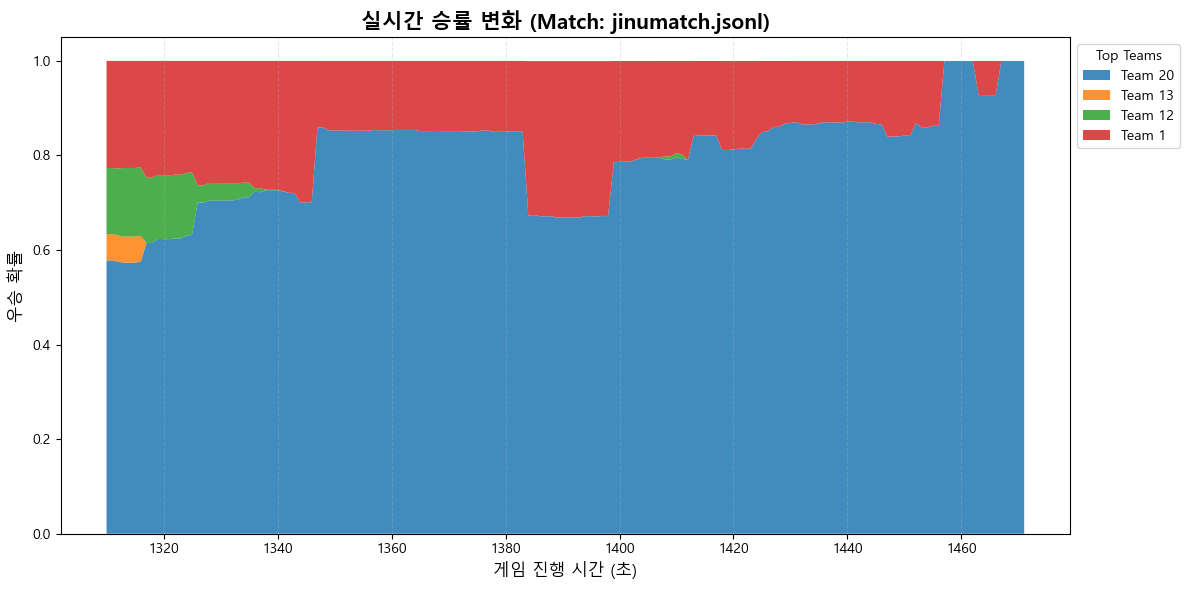

✨ 그래프 생성 완료!


In [54]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import math

# ==========================================
# [1] 설정 (Configuration)
# ==========================================
# 분석할 로그 파일 경로 (여기에 새 파일명을 넣으세요!)
TARGET_LOG_FILE = 'jinumatch.jsonl' 
MODEL_PATH = 'pubg_win_model.pth' # 미리 학습된 모델

# 모델 파라미터 (학습 때와 동일해야 함)
MAX_TEAMS = 10
PLAYER_FEATS = 11
TEAM_FEATS = 2
HIDDEN_DIM = 32
DROPOUT = 0.3

# 데이터 추출 파라미터
TIME_INTERVAL_SEC = 1
START_ALIVE_THRESHOLD = 10
AI_TEAM_ID_START = 200
MAX_AI_RATIO = 0.4
STALE_THRESHOLD_SEC = 30
DANGER_RADIUS_CM = 30000

# ==========================================
# [2] 모델 구조 정의 (학습 코드와 동일)
# ==========================================
class WinPredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.p_embed = nn.Sequential(
            nn.Linear(PLAYER_FEATS, HIDDEN_DIM),
            nn.ReLU(),
            nn.Dropout(DROPOUT)
        )
        self.p_enc = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=HIDDEN_DIM, nhead=2, batch_first=True, dropout=DROPOUT), 
            num_layers=1
        )
        self.t_embed = nn.Sequential(
            nn.Linear(HIDDEN_DIM + TEAM_FEATS, HIDDEN_DIM),
            nn.ReLU(),
            nn.Dropout(DROPOUT)
        )
        self.t_enc = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=HIDDEN_DIM, nhead=4, batch_first=True, dropout=DROPOUT), 
            num_layers=2
        )
        self.head = nn.Linear(HIDDEN_DIM, 1)

    def forward(self, p, t):
        B, T, P, F = p.shape
        p_flat = p.view(B * T, P, F)
        p_emb = self.p_embed(p_flat)
        p_out = self.p_enc(p_emb)
        team_p_vec, _ = torch.max(p_out, dim=1) 
        team_p_vec = team_p_vec.view(B, T, -1)
        team_input = torch.cat([team_p_vec, t], dim=-1)
        team_emb = self.t_embed(team_input)
        team_out = self.t_enc(team_emb)
        score = self.head(team_out).squeeze(-1)
        return score

# ==========================================
# [3] 헬퍼 함수
# ==========================================
def get_distance(x1, y1, x2, y2): return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def get_item_level(item_id):
    if not isinstance(item_id, str): return 0
    if 'Lv3' in item_id: return 3
    if 'Lv2' in item_id: return 2
    if 'Lv1' in item_id: return 1
    if 'Head' in item_id:
        if 'Head_G' in item_id: return 3
        if 'Head_F' in item_id: return 2
        if 'Head_E' in item_id: return 1
    if 'Armor' in item_id or 'Vest' in item_id:
        if 'Armor_E' in item_id or 'Vest_E' in item_id: return 3 # 또는 Lv3 명시적 체크
        if 'Armor_D' in item_id or 'Vest_D' in item_id: return 2
        if 'Armor_C' in item_id or 'Vest_C' in item_id: return 1
    return 0

def get_throwable_type(item_id):
    if not isinstance(item_id, str): return None
    if 'Smoke' in item_id: return 'smoke'
    if 'Grenade' in item_id and 'Bluezone' not in item_id: return 'grenade'
    return None

def calculate_angle(my_pos, enemy1_pos, enemy2_pos):
    v1_x = enemy1_pos[0] - my_pos[0]; v1_y = enemy1_pos[1] - my_pos[1]
    v2_x = enemy2_pos[0] - my_pos[0]; v2_y = enemy2_pos[1] - my_pos[1]
    norm1 = math.sqrt(v1_x**2 + v1_y**2); norm2 = math.sqrt(v2_x**2 + v2_y**2)
    if norm1 == 0 or norm2 == 0: return 0
    dot_product = (v1_x * v2_x) + (v1_y * v2_y)
    cos_theta = max(-1.0, min(1.0, dot_product / (norm1 * norm2)))
    return math.degrees(math.acos(cos_theta))

def process_single_match(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            logs = [json.loads(line) for line in f]
    except Exception as e:
        print(f"Error: {e}")
        return None

    # AI Ratio Check
    all_players = set(); human_players = set()
    for log in logs:
        if log.get('_T') == 'LogPlayerPosition':
            c = log.get('character', {})
            name = c.get('name')
            if name:
                all_players.add(name)
                if c.get('teamId', -1) < AI_TEAM_ID_START: human_players.add(name)
    
    if not all_players: return None

    # Init
    current_alive = 100
    team_players = {}
    p_status = {}
    p_gear = {}
    p_throw = {}
    p_kills = {}
    curr_safe_zone = {'x': 400000, 'y': 400000}
    
    next_snap = 0
    recording = False
    target_teams = set()
    data_rows = []

    # Build Teams
    for log in logs:
        if log.get('_T') == 'LogPlayerPosition':
            c = log.get('character', {})
            tid = c.get('teamId', -1)
            name = c.get('name')
            if tid != -1 and tid < AI_TEAM_ID_START and name:
                if tid not in team_players: team_players[tid] = set()
                team_players[tid].add(name)

    # Process Logs
    for log in logs:
        log_type = log.get('_T')
        elapsed = log.get('elapsedTime', 0)
        
        if log_type == 'LogGameStatePeriodic':
            sz = log.get('gameState', {}).get('safetyZonePosition', {})
            if sz: curr_safe_zone = {'x': sz.get('x'), 'y': sz.get('y')}

        elif log_type == 'LogPlayerPosition':
            if 'numAlivePlayers' in log: current_alive = log['numAlivePlayers']
            c = log.get('character', {})
            name = c.get('name')
            if name:
                p_status[name] = {
                    'hp': c.get('health', 0),
                    'dbno': 1 if c.get('isDBNO', False) else 0,
                    'veh': 1 if c.get('isInVehicle', False) else 0,
                    'loc': c.get('location', {}),
                    'last_update': elapsed
                }

        elif log_type == 'LogItemEquip':
            item = log.get('item', {})
            name = log.get('character', {}).get('name')
            if name:
                lvl = get_item_level(item.get('itemId', ''))
                if lvl > 0:
                    if name not in p_gear: p_gear[name] = {'helm': 0, 'vest': 0}
                    if 'Head' in item.get('itemId', ''): p_gear[name]['helm'] = lvl
                    else: p_gear[name]['vest'] = lvl

        elif log_type == 'LogItemPickup':
            item = log.get('item', {})
            name = log.get('character', {}).get('name')
            if name:
                tt = get_throwable_type(item.get('itemId', ''))
                if tt:
                    if name not in p_throw: p_throw[name] = {'smoke': 0, 'nade': 0}
                    if tt == 'smoke': p_throw[name]['smoke'] += item.get('stackCount', 1)
                    elif tt == 'grenade': p_throw[name]['nade'] += item.get('stackCount', 1)

        elif log_type == 'LogPlayerKillV2':
            k = log.get('killer', {})
            v = log.get('victim', {})
            if v and v.get('name') in p_status: p_status[v['name']]['hp'] = 0
            if k and k.get('name'):
                kname = k['name']
                p_kills[kname] = p_kills.get(kname, 0) + 1

        # Trigger
        if not recording:
            if elapsed > 300 and current_alive <= START_ALIVE_THRESHOLD:
                recording = True
                next_snap = elapsed
                for tid, mems in team_players.items():
                    alive = False
                    for m in mems:
                        s = p_status.get(m, {})
                        if s.get('hp', 0) > 0 and (elapsed - s.get('last_update', 0) <= STALE_THRESHOLD_SEC):
                            alive = True; break
                    if alive: target_teams.add(tid)

        # Snapshot
        if recording and elapsed >= next_snap:
            active_teams_centroids = {}
            for tid in target_teams:
                alive_x, alive_y = [], []
                alive = False
                for m in team_players[tid]:
                    s = p_status.get(m, {})
                    if s.get('hp', 0) > 0 and (elapsed - s.get('last_update', 0) <= STALE_THRESHOLD_SEC):
                        alive = True
                        if s.get('loc'):
                            alive_x.append(s['loc'].get('x', 0))
                            alive_y.append(s['loc'].get('y', 0))
                if alive and alive_x:
                    active_teams_centroids[tid] = (np.mean(alive_x), np.mean(alive_y))

            # Z Calc
            all_z = []
            for tid in target_teams:
                for m in team_players[tid]:
                    s = p_status.get(m, {})
                    if s.get('hp', 0) > 0 and s.get('loc'):
                        all_z.append(s['loc'].get('z', 0))
            z_mean = np.mean(all_z) if all_z else 0
            z_std = np.std(all_z) + 1e-5 if all_z else 1

            for tid in target_teams:
                mems = list(team_players[tid])
                team_row = {'time_sec': next_snap, 'team_id': tid}
                alive_cnt = 0
                total_hp = 0
                
                for i in range(4):
                    prefix = f"P{i+1}_"
                    if i < len(mems):
                        m = mems[i]
                        s = p_status.get(m, {})
                        g = p_gear.get(m, {'helm': 0, 'vest': 0})
                        t = p_throw.get(m, {'smoke': 0, 'nade': 0})
                        k = p_kills.get(m, 0)
                        
                        if s.get('hp', 0) > 0 and (elapsed - s.get('last_update', 0) <= STALE_THRESHOLD_SEC):
                            alive_cnt += 1
                            total_hp += s['hp']
                            loc = s.get('loc', {'x':0, 'y':0, 'z':0})
                            
                            team_row[prefix+'health'] = s['hp']
                            team_row[prefix+'groggy'] = s['dbno']
                            team_row[prefix+'helm'] = g['helm']
                            team_row[prefix+'vest'] = g['vest']
                            team_row[prefix+'smoke'] = t['smoke']
                            team_row[prefix+'nade'] = t['nade']
                            team_row[prefix+'kill'] = k
                            team_row[prefix+'veh'] = s['veh']
                            team_row[prefix+'rel_x'] = loc.get('x', 0) - curr_safe_zone['x']
                            team_row[prefix+'rel_y'] = loc.get('y', 0) - curr_safe_zone['y']
                            team_row[prefix+'z'] = (loc.get('z', 0) - z_mean) / z_std
                        else:
                            for feat in ['health','groggy','helm','vest','smoke','nade','kill','veh','rel_x','rel_y','z']: team_row[prefix+feat] = 0
                    else:
                        for feat in ['health','groggy','helm','vest','smoke','nade','kill','veh','rel_x','rel_y','z']: team_row[prefix+feat] = 0

                nearest_dist = 999999; max_angle = 0
                if tid in active_teams_centroids:
                    my_pos = active_teams_centroids[tid]
                    nearby = []
                    for etid, epos in active_teams_centroids.items():
                        if tid == etid: continue
                        dist = get_distance(my_pos[0], my_pos[1], epos[0], epos[1])
                        if dist < nearest_dist: nearest_dist = dist
                        if dist <= DANGER_RADIUS_CM: nearby.append(epos)
                    
                    if len(nearby) >= 2:
                        for i in range(len(nearby)):
                            for j in range(i+1, len(nearby)):
                                angle = calculate_angle(my_pos, nearby[i], nearby[j])
                                if angle > max_angle: max_angle = angle
                
                if nearest_dist == 999999: nearest_dist = -1

                team_row['num_alive'] = alive_cnt
                team_row['total_health'] = round(total_hp, 2)
                data_rows.append(team_row)
            next_snap += TIME_INTERVAL_SEC

    return pd.DataFrame(data_rows).round(2) if data_rows else None

# ==========================================
# [4] 실행부 (분석 및 시각화)
# ==========================================
if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # 폰트 설정 (한글 깨짐 방지)
    if os.name == 'nt': plt.rc('font', family='Malgun Gothic')
    plt.rc('axes', unicode_minus=False)

    if not os.path.exists(TARGET_LOG_FILE):
        print(f"❌ 분석할 파일({TARGET_LOG_FILE})이 없습니다.")
        exit()
    if not os.path.exists(MODEL_PATH):
        print(f"❌ 모델 파일({MODEL_PATH})이 없습니다.")
        exit()

    # 1. 모델 로드 (weights_only=False)
    checkpoint = torch.load(MODEL_PATH, map_location=device, weights_only=False)
    
    model = WinPredictor().to(device)
    model.load_state_dict(checkpoint['model'])
    model.eval()
    
    p_scaler = checkpoint['p_scaler']
    t_scaler = checkpoint['t_scaler']
    
    print(f"✅ 모델 로드 완료 (Device: {device})")

    # 2. 데이터 추출
    print(f"🚀 '{TARGET_LOG_FILE}' 분석 중...")
    df = process_single_match(TARGET_LOG_FILE)
    
    if df is None or df.empty:
        print("❌ 데이터 추출 실패")
        exit()
    df.to_csv("jinumatch.csv",index = False)
    print(f"✅ 데이터 추출 완료 ({len(df)} 스냅샷)")

    # 3. 추론 (Inference)
    time_steps = df['time_sec'].unique()
    history_probs = []
    
    # 초기 생존 팀 기준으로 그래프 색상/순서 고정
    initial_teams = df[df['time_sec'] == time_steps[0]]['team_id'].values
    team_to_idx = {tid: i for i, tid in enumerate(initial_teams)}
    
    # 변수 목록 (학습과 동일)
    P_COLS = ['health', 'groggy', 'helm', 'vest', 'smoke', 'nade', 'kill', 'veh', 'rel_x', 'rel_y', 'z']
    T_COLS = ['num_alive', 'total_health']

    print("📊 승률 계산 중...")
    with torch.no_grad():
        for t_sec in time_steps:
            step_df = df[df['time_sec'] == t_sec]
            
            # 입력 텐서 (Batch=1)
            p_tensor = np.zeros((1, MAX_TEAMS, 4, PLAYER_FEATS))
            t_tensor = np.zeros((1, MAX_TEAMS, TEAM_FEATS))
            
            # 데이터 채우기
            for _, row in step_df.iterrows():
                tid = row['team_id']
                if tid not in team_to_idx: continue
                idx = team_to_idx[tid]
                if idx >= MAX_TEAMS: continue
                
                # Player Data Scaling
                for i in range(4):
                    cols = [f"P{i+1}_{c}" for c in P_COLS]
                    raw_p = row[cols].values.reshape(1, -1)
                    p_tensor[0, idx, i, :] = p_scaler.transform(raw_p)
                
                # Team Data Scaling
                raw_t = row[T_COLS].values.reshape(1, -1)
                t_tensor[0, idx, :] = t_scaler.transform(raw_t)
            
            # 모델 실행
            p_in = torch.FloatTensor(p_tensor).to(device)
            t_in = torch.FloatTensor(t_tensor).to(device)
            
            logits = model(p_in, t_in)
            probs = torch.nn.functional.softmax(logits, dim=1).cpu().numpy()[0]
            
            # 유효한 팀 수까지만 자르기
            valid_len = min(len(team_to_idx), MAX_TEAMS)
            history_probs.append(probs[:valid_len])

    # 4. 시각화
    history_probs = np.array(history_probs).T # (Teams, Time)
    
    # 마지막 시점 승률 높은 순으로 정렬 (Top 5)
    last_probs = history_probs[:, -1]
    top_indices = np.argsort(last_probs)[::-1][:5]
    
    plt.figure(figsize=(12, 6))
    labels = [f"Team {list(team_to_idx.keys())[i]}" for i in top_indices]
    
    # Stackplot
    plt.stackplot(time_steps, history_probs[top_indices], labels=labels, alpha=0.85)
    
    plt.title(f"실시간 승률 변화 (Match: {TARGET_LOG_FILE})", fontsize=15, fontweight='bold')
    plt.xlabel("게임 진행 시간 (초)", fontsize=12)
    plt.ylabel("우승 확률", fontsize=12)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Top Teams")
    plt.grid(axis='x', linestyle='--', alpha=0.3)
    plt.tight_layout()
    
    plt.show()
    print("✨ 그래프 생성 완료!")